Comparison of Filtering Methods
===

This notebook tests/demonstrates three lowpass filtering methods.  The
typical use is for time series filtering, but there is no reason these
methods cannot be used to filter coordinate series, or the lowpass
result subtracted from the original signal to get a highpass series.

The text here is high level, and belies a dim recollection of proper
signal processing.  DSP experts will be offended, but they are not
the intended audience.

** FIR **

Finite impulse response, which is a glorified moving average.  Compared
to a standard "boxcar" moving average, we choose a Hanning window for
a smoother response.  This method deals well with NaNs (NaNs should be left
in so that the input has an evenly spaced timebase).  The cutoff period
is where the frequency response falls to 0.5 of the DC response.  A tidal
filter should probably have a cutoff of about 72 hours to be sure that very
little diurnal signal gets through.

** IIR **

Infinite impulse response, where each output point is calculated as a weighted
sum of recent output points and recent input points.  This method allows
for fast filtering and sharply defined frequency responses.  The "order" of
the method defines how many "recent" inputs and outputs are considered.  Higher
order allows for sharper cutoffs between pass frequencies and stop frequencies,
at the expense of possible numerical stability issues.  Note that the cutoff 
period for the IIR method here is not the same as for FIR.  The response 
falls to 0.5 at twice the cutoff period.  A tidal filter can reasonably have
a cutoff of 36 hours, which means that very little energy gets through at 36
hours, and only half of the energy at 72 hours get through.  

For example, an FIR filter with a cutoff at 36 hours will
still pass half of the input signal at a 36-hour period.  The IIR code would 
require a "cutoff" of 18 hours to get the same half-pass effect at 36 hours.
This may change in the future, but will require a new function since
there is code that depends on the current implementation.

** Godin **

This is an old-school moving average filter for removing tides from time series.
It is intended to be applied to hourly data, though the implementation here 
will approximate a Godin filter on time series with arbitrary (but constant!)
time steps.

All of the methods preserve the length of the input data, but generally produce
unusable results near the start and end of the output.  

In [32]:
from stompy import filters, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [69]:
# Sample data -- all times in hours
dt=0.1
x=np.arange(0,100,dt)
y=np.random.random(len(x))

target_cutoff=36.0

y_fir=filters.lowpass_fir(y,int(target_cutoff/dt))
y_iir=filters.lowpass(y,dt=dt,cutoff=target_cutoff/2.)
y_godin=filters.lowpass_godin(y,in_t_days=x/24.)


Construct a noise signal and plot the result of applying each method.

<IPython.core.display.Javascript object>


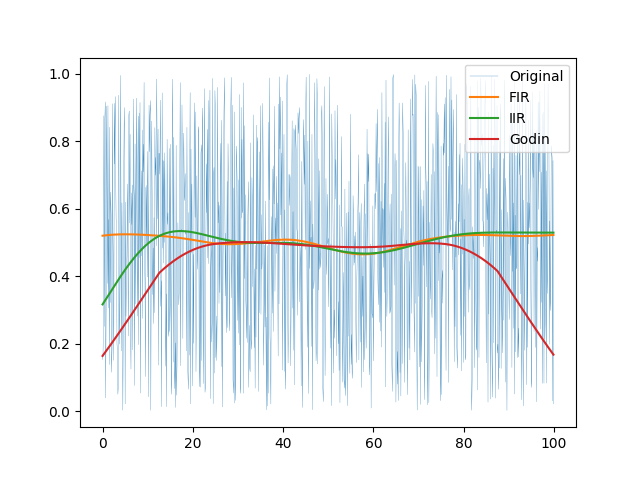

In [70]:
fig,ax=plt.subplots()
ax.plot(x,y,label='Original',lw=0.2)
ax.plot(x,y_fir,label='FIR')
ax.plot(x,y_iir,label='IIR')
ax.plot(x,y_godin,label='Godin')
ax.legend(loc='upper right')

Frequency Response
---

This is a brute-force approach to frequency response to 
demonstrate the details of what each method does to 
incoming frequencies.

Each filter is applied to a collection of sine-curve 
inputs of varying frequencies.  For each frequency,
the gain is computed by comparing the RMS magnitude
of the input and output waveforms.



In [94]:
periods=10**(np.linspace(np.log10(1),np.log10(400),150))
freqs=1./periods

# A single time base that's good enough for the full range
x=np.arange(0,4*periods[-1],periods[0]/4.)
dt=np.median(np.diff(x))

target_cutoff=36.0

freq=freqs[0]

y=np.cos(2*np.pi*freq*x)
win=np.hanning(len(y))

def fir36hour(y):
    return filters.lowpass_fir(y,int(2*target_cutoff/dt))

def iir36hour(y):
    return filters.lowpass(y,dt=dt,cutoff=target_cutoff,order=4)

def godin(y):
    return filters.lowpass_godin(y,in_t_days=x/24.)

def scan(f):
    gains=[]
    for freq in freqs:
        y=np.cos(2*np.pi*freq*x)
        y_filt=f(y)
        mag_in=utils.rms( win*y )
        mag_out=utils.rms( win*y_filt)
        gains.append( (freq,mag_out/mag_in) ) 
    return np.array(gains)

fir_gains=scan(fir36hour)
iir_gains=scan(iir36hour)
godin_gains=scan(godin)

<IPython.core.display.Javascript object>


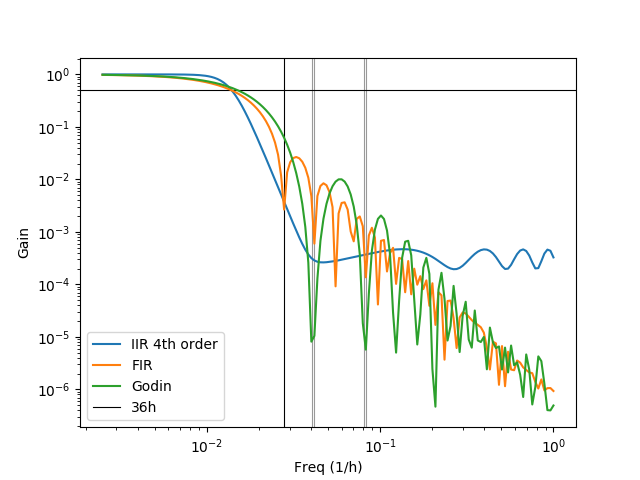

In [96]:
fig,ax=plt.subplots()
ax.loglog(iir_gains[:,0],iir_gains[:,1],label='IIR 4th order')
ax.loglog(fir_gains[:,0],fir_gains[:,1],label='FIR')
ax.loglog(godin_gains[:,0],godin_gains[:,1],label='Godin')

ax.axvline(1./target_cutoff,label='36h',color='k',lw=0.8,zorder=-1)
ax.axvline(1./24,label='__nolabel__',color='0.6',lw=0.8,zorder=-1)
ax.axvline(1./24.84,label='__nolabel__',color='0.6',lw=0.8,zorder=-1)
ax.axvline(1./12,label='__nolabel__',color='0.6',lw=0.8,zorder=-1)
ax.axvline(1./12.42,label='__nolabel__',color='0.6',lw=0.8,zorder=-1)


ax.axhline(0.5,label='__nolabel__',color='k',lw=0.8,zorder=-1)


ax.set_xlabel('Freq (1/h)')
ax.set_ylabel('Gain')
ax.legend(loc='lower left')

Discussion of Response
---

The plot shows that IIR has the fastest rolloff above the pass band, consistent
with it being a 4th order filter.  A 2nd order IIR filter would show a rolloff
similar to but smoother than the FIR and Godin filters.  It may be useful to
note that the Godin filter is really an FIR filter where the window is implicitly
defined by the moving averages as opposed to a closed form like the Hanning
window.  Both Godin and FIR have 2nd order rolloff above the passband.

An interesting feature of the Godin filter, and a good argument for its use,
is that it has deep notches at the dominant tidal frequencies, near 24h and
12h.  For that reason it is actually better at rejecting tidal-band energy
than either of the other two methods.